### This notebook is for reproducing a part of the paper results' subsection "Multi-scale hierarchical $\gamma$-fused structure-function modular organization" and generate the panels of the figures S2 and S3.  The objective of the notebook is to represent the tree of the optimal parcellation and compute different tree-based measures. The measures can help to interpret the modules and their underlying structure, and they are:
### 1. Multiscale index (MSI)
### 2. Module size (MS)
### 3. Module height (MH)

In [1]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.io_functions import load_data
from src.plotting_functions import *
import os
import json
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import (
    linkage,
    fcluster,
    dendrogram,
    leaves_list,
    set_link_color_palette,
)
from matplotlib import colors
from nilearn.image import iter_img
import seaborn as sns

First, it's needed to define the connectome size, it's possible to choose between the following number of nodes: 183, 391, 568, 729, 964, 1242, 1584, 1795, 2165. But it is recommended to use the best initial parcellation (in this case 2165 nodes).

In [2]:
project_path = "/workspaces/bha2"
CONN_SIZE = 2165

In order to not reload the individual matrices or recalculate the population average, the code checks if the population average matrices are already in the bha2/tmp folder. If they are not, the code will load the individual matrices and calculate the population average matrices.

In [3]:
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(CONN_SIZE), "sc")
    )
    fc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(CONN_SIZE), "fc")
    )
    fcm, scm = connectome_average(fc_group, sc_group)
    np.save(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(CONN_SIZE) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


Preprocessing of the SC and FC population matrices is needed before building the dendrogram trees. The preprocessing includes the following steps:
* Remove ROIs disconnected in the SC matrix
* Calculate the density of the SC matrix and apply a threshold to the FC matrix to keep the same density in both matrices
* Remove ROIs disconnected in the thresholded SC matrix
* Binarize both matrices

In [4]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
    len(scm_nonzero.flatten())
)
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
    zero_rows_fc, fcm_thr, scm_nonzero
)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0)

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


Loading the initial parcellation without the disconnected ROIs and the opitmal parcellation.

In [6]:
initial_parcellation = nib.load(
    os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(CONN_SIZE),
        "initial_parcellation.nii.gz",
    ))
initial_parcellation_data = initial_parcellation.get_fdata()

optimal_parcellation = nib.load(
    os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(CONN_SIZE),
        "optimal_parcellation.nii.gz",
    )
)
optimal_parcellation_data = optimal_parcellation.get_fdata()

It is necessary to define some global variables for the rest of the analyses. The variables are:
- TREE_MIN and TREE_MAX: for computational efficiency, the minimum and maximum number of tree levels to be considered in the MSI. For all the modules, the MSI is in that range.
- SM_THRESH: as in the previous notebooks, the threshold of minimum size of the modules to be considered in the analyses.
- OPT_GAMMA and OPT_LEVEL: the optimal $\gamma$ and tree level of the optimal parcellation.

And then, load the tree dictionary.

In [7]:
TREE_MIN = 2
TREE_MAX = 200
SM_THRESH = 5
OPT_GAMMA = 0.7
OPT_LEVEL = 28
tree = json.loads(
                    open(
                        os.path.join(
                            project_path,
                            "data",
                            "processed",
                            "n" + str(CONN_SIZE),
                            "tree_g_" + str(OPT_GAMMA) + ".json",
                        )
                    ).read()
)
opt_level_modules, opt_level_labels = level_from_tree(tree, OPT_LEVEL)
opt_level_module_sizes = np.array([len(x) for x in opt_level_modules])

For drawing the results, we define two colormaps, one for the tree and other for the connectivity matrices.

In [8]:
color_list = []
for name, hex in colors.cnames.items():
    rgb = colors.hex2color(hex)
    # We define the brightness of a color, to avoid too bright colors
    L = pow((pow(rgb[0], 2) + pow(rgb[1], 2) + pow(rgb[2], 2)), 0.5) / pow(3, 0.5)
    if L < 0.85:
        color_list.append(name)
np.random.seed(3)
color_list = list(np.random.choice(color_list, OPT_LEVEL, replace=False))
# removing from the list colors corresponding to one-roi modules
color_list_dend = np.delete(color_list, np.where(opt_level_module_sizes == 1)[0]).tolist()
# removing from the list colors corresponding to modules with less than SM_THRESH rois
color_list_mat = np.delete(color_list, np.where(opt_level_module_sizes < SM_THRESH)[0]).tolist()

Here is represented the full tree and each color represent a module of the optimal parcellation. In the tree there are also marked some examples of levels and also the defintion of the MSI and MS. The figure is saved in the folder `bha2/data/figures`.

/tmp/ipykernel_2587556/1957773395.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(cc, "weighted", "correlation")


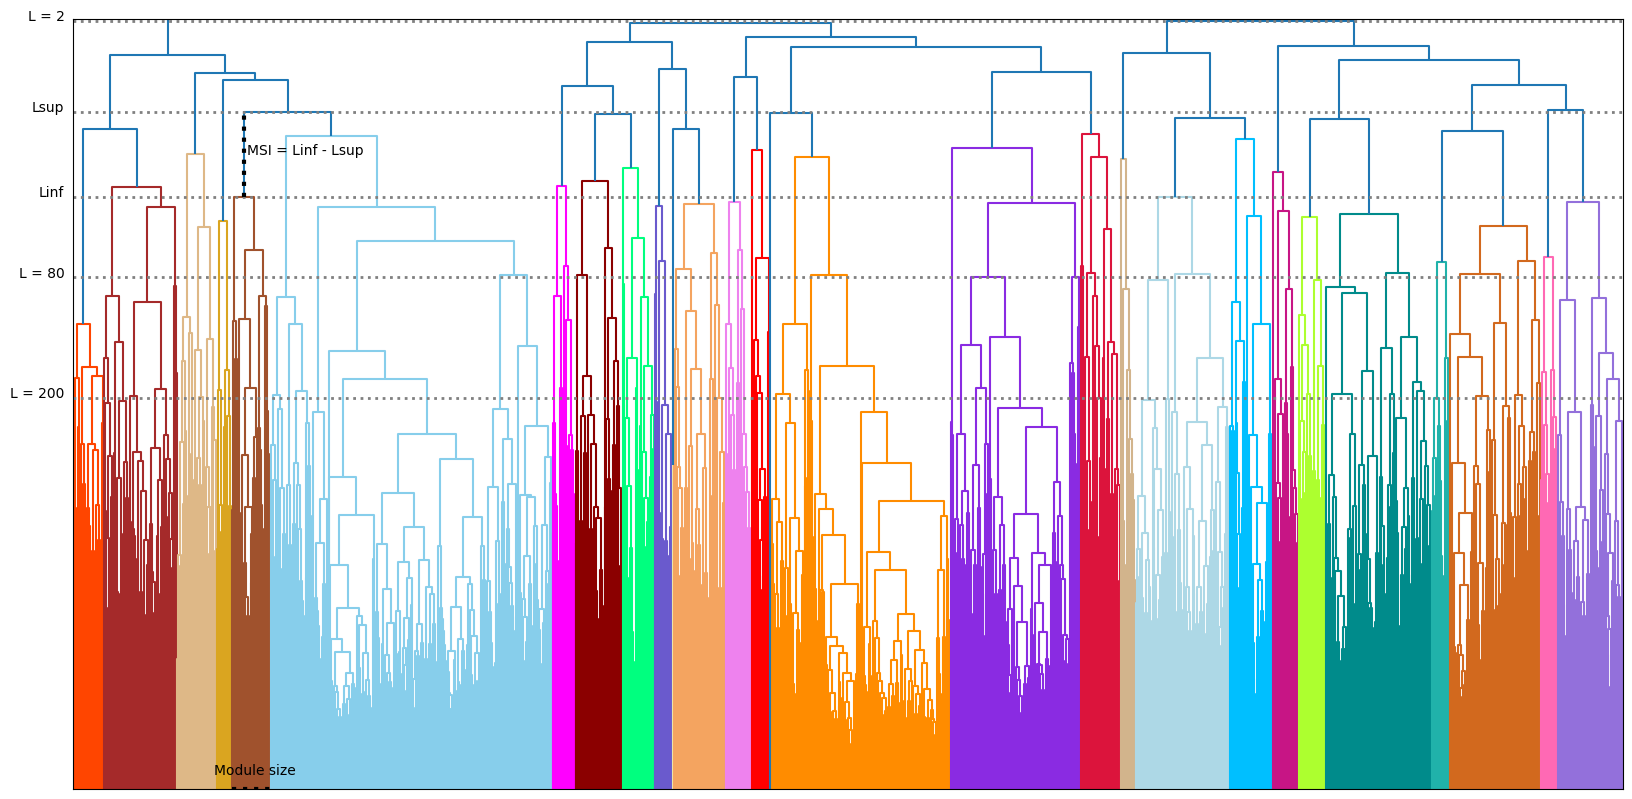

In [9]:
plt.figure(figsize=(20, 10))
# calculating again the linkage matrix, for plotting purposes
cc = matrix_fusion(OPT_GAMMA,fcm_bin, scm_bin)
Z = linkage(cc, "weighted", "correlation")

# storing the height in the tree of each node
height_in_tree_sorted = Z[:, 2][::-1]

set_link_color_palette(color_list_dend)

# we represent the dendrogram assigning a color to each module, the minus 2 is because the tree starts at level 2
den = dendrogram(
    Z, color_threshold=height_in_tree_sorted[OPT_LEVEL - 2], no_labels=True
)
plt.ylim(0, 1)
plt.yticks([])

# drawing some examples of levels
plot_hline_dend(height_in_tree_sorted[2], "L = 2")
plot_hline_dend(height_in_tree_sorted[80], "L = 80")
plot_hline_dend(height_in_tree_sorted[200], "L = 200")

# drawing the meanings of MSI and module size for module 5
module_selected = 5

module_rois = tree["lvl_" + str(OPT_LEVEL) + "_mod_" + str(module_selected)]
# checking in which levels the module is present as a whole
module_presence_in_tree = []
for l in range(TREE_MIN, TREE_MAX):
    level, labels = level_from_tree(tree, l)
    for module in level:
        if module == module_rois:
            module_presence_in_tree.append(l)
            break
# finding the level and height before and after the module is present as a whole
lvl_bf_module = min(module_presence_in_tree) - 2
lvl_af_module = max(module_presence_in_tree) - 1
height_af = height_in_tree_sorted[lvl_af_module]
height_bf = height_in_tree_sorted[lvl_bf_module]

# finding in the dendrogram branches which correspond to the module
x_loc, y_loc = np.where(np.array(den["dcoord"]) == height_af)
x = den["icoord"][x_loc[2]][y_loc[2]]

# plotting in the tree the module size and the MSI
plot_hline_dend(height_bf, "Lsup")
plot_hline_dend(height_af, "Linf")
plot_vline_dend(x, height_bf, height_af, "MSI = Linf - Lsup")
plot_module_size_dend(Z, module_rois, den)

plt.savefig(
    os.path.join(project_path, "data", "figures", "opt_parcell_tree.svg"),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

For describing the MH, a dendrogram  inset is also represented, together with the meaning of ROI (or node) height. The figure is saved in the folder `bha2/data/figures`.

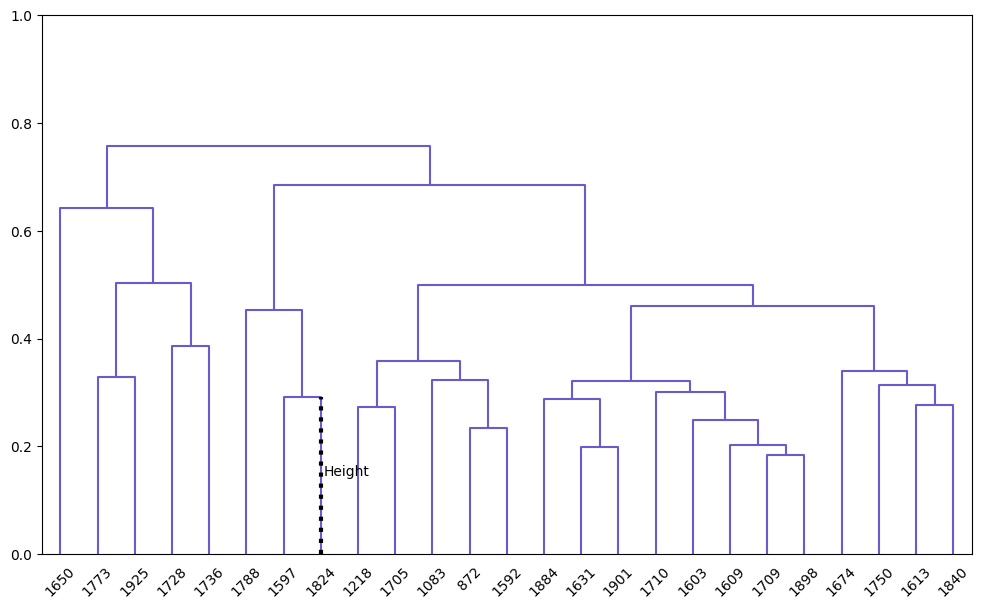

In [10]:
plt.figure(figsize=(12, 7))

# We choose for example module 10, as it has not many nodes
module_selected = 10
module_rois = tree["lvl_" + str(OPT_LEVEL) + "_mod_" + str(module_selected)]
leaves = leaves_list(Z)
loc_in_tree = np.where(np.in1d(leaves, module_rois))[0]
# assigning the same color of the full dendrogram
subtree_color = den["leaves_color_list"][loc_in_tree[0]]
# calculating the module linkage matrix
cc_mod = matrix_fusion(OPT_GAMMA, fcm_bin[module_rois, :], scm_bin[module_rois, :])
Z_mod = linkage(cc_mod, "weighted", "correlation")
height_in_tree_sorted_mod = Z_mod[:, 2][::-1]

# plotting the new sub-dendrogram
den_mod = dendrogram(
    Z_mod, color_threshold=0, above_threshold_color=subtree_color, labels=module_rois
)
plt.ylim(0, 1)

leaves_first_list_sorted_mod = Z_mod[:, 0][::-1].astype(int)
leaves_second_list_sorted_mod = Z_mod[:, 1][::-1].astype(int)

# draw the meaning of height for roi 19, as an example
roi_selected = 19
idx_in_first_list_mod = np.where(leaves_first_list_sorted_mod == roi_selected)[0]
idx_in_second_list_mod = np.where(leaves_second_list_sorted_mod == roi_selected)[0]
if idx_in_first_list_mod.size > 0:
    roi_height = height_in_tree_sorted_mod[idx_in_first_list_mod[0]]
    x_loc, y_loc = np.where(np.array(den_mod["dcoord"]) == roi_height)
    x = den_mod["icoord"][x_loc[0]][y_loc[0]]
elif idx_in_second_list_mod.size > 0:
    roi_height = height_in_tree_sorted_mod[idx_in_second_list_mod[0]]
    x_loc, y_loc = np.where(np.array(den_mod["dcoord"]) == roi_height)
    x = den_mod["icoord"][x_loc[0]][y_loc[1]]

plot_vline_dend(x, roi_height, 0, "Height")

plt.savefig(
    os.path.join(
        project_path, "data", "figures", "opt_parcell_mod_inset_example.svg"
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

In order to see the structure of the modules in the network, we also represented the re-ordered SC and FC matrices and colored the modules with the same colors as in the tree. The figure is saved in the folder `bha2/data/figures`. This plot is a part of the figure 1.

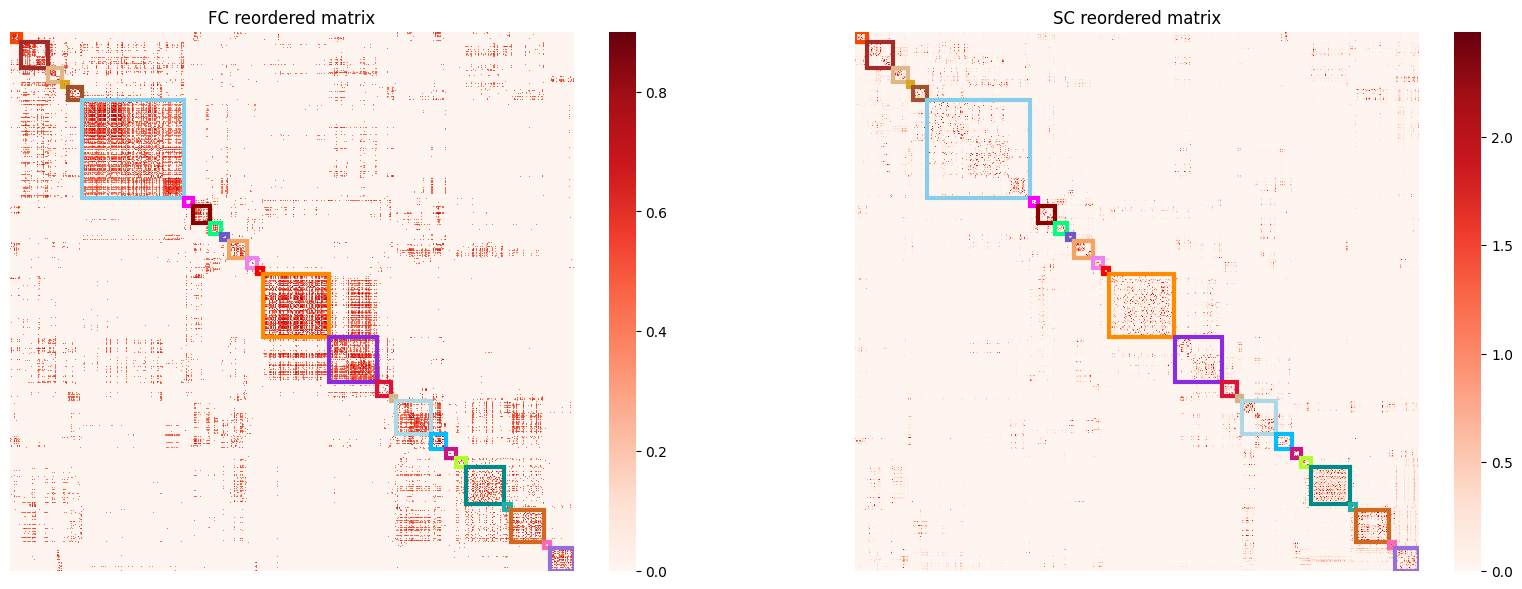

In [11]:
fcm_nonzero_reordered = np.zeros(fcm_nonzero.shape)
scm_nonzero_reordered = np.zeros(scm_nonzero.shape)
fcm_nonzero_reordered = fcm_nonzero[np.hstack(opt_level_modules), :]
fcm_nonzero_reordered = fcm_nonzero_reordered[:, np.hstack(opt_level_modules)]
scm_nonzero_reordered = scm_nonzero[np.hstack(opt_level_modules), :]
scm_nonzero_reordered = scm_nonzero_reordered[:, np.hstack(opt_level_modules)]



plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(fcm_nonzero_reordered, ax=ax[0], cmap="Reds")
ax[0].set_title("FC reordered matrix")
    
sns.heatmap(np.log10(scm_nonzero_reordered+1), ax=ax[1], cmap="Reds")
ax[1].set_title("SC reordered matrix")

idx = 0
for i in range(len(opt_level_module_sizes)):
    if opt_level_module_sizes[i] > SM_THRESH:
        rect_pos=np.sum(opt_level_module_sizes[:i])
        ax[0].add_patch(plt.Rectangle((rect_pos, rect_pos), opt_level_module_sizes[i], opt_level_module_sizes[i], fill=False, edgecolor=color_list_mat[idx], lw=3))
        ax[1].add_patch(plt.Rectangle((rect_pos, rect_pos), opt_level_module_sizes[i], opt_level_module_sizes[i], fill=False, edgecolor=color_list_mat[idx], lw=3))
        idx += 1

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.savefig(
    os.path.join(
        project_path, "data", "figures", "connectome_reordered.png"
    ),
    dpi=300,
    bbox_inches="tight",
    format="png",
)

After describing each tree measure, we compute and store them in a dataframe for the subsequent figures.

In [25]:
# The height information is stored in two columns of the linkage matrix
leaves_first_list_sorted = Z[:, 0][::-1].astype(int)
leaves_second_list_sorted = Z[:, 1][::-1].astype(int)

module_MSI = []
module_size = []
module_mean_heights = []
module_intra_strength = []

for module_indices in range(1, OPT_LEVEL + 1):
    module_rois = tree["lvl_" + str(OPT_LEVEL) + "_mod_" + str(module_indices)]
    if len(module_rois) > SM_THRESH:
        cc = (OPT_GAMMA * fcm_bin) + ((1 - OPT_GAMMA) * scm_bin)
        module_intra_strength.append(cc[module_rois, :][:, module_rois].sum(dtype=float)/len(module_rois))
        heights_from_first_list = height_in_tree_sorted[
            np.where(np.in1d(leaves_first_list_sorted, module_rois))[0]
        ]
        heights_from_second_list = height_in_tree_sorted[
            np.where(np.in1d(leaves_second_list_sorted, module_rois))[0]
        ]
        module_mean_heights.append(
            np.mean(np.hstack((heights_from_first_list, heights_from_second_list)))
        )
        module_presence_in_tree = []
        for l in range(TREE_MIN, TREE_MAX):
            level, labels = level_from_tree(tree, l)
            for module in level:
                if module == module_rois:
                    module_presence_in_tree.append(l)
                    break

        module_MSI.append(len(module_presence_in_tree))
        module_size.append(len(module_rois))


module_measures = pd.DataFrame({"module MSI": module_MSI, 
    "module intra strength": module_intra_strength,
    "module size": module_size, 
    "module height": module_mean_heights})

The MSI is represented in a brain plot. The figure is saved in the folder `bha2/data/figures` and the image in the folder `bha2/data/processed/CONN_SIZE`.

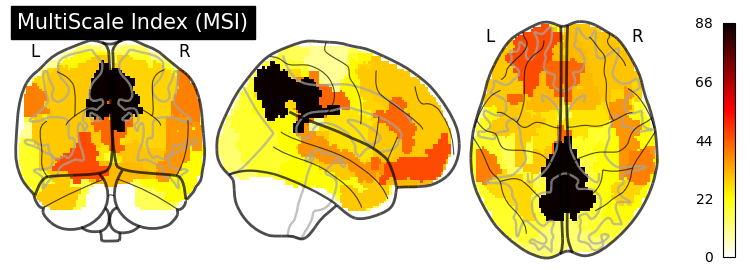

In [32]:
module_MSI_img = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)

for idx, MSI in enumerate(module_measures["module MSI"].values):
    module_MSI_img[optimal_parcellation_data == idx+1] = MSI

plotting.plot_glass_brain(
    nib.Nifti1Image(module_MSI_img, affine=initial_parcellation.affine),
    colorbar=True,
    title="MultiScale Index (MSI)",
)
plt.savefig(
    os.path.join(
        project_path, "data", "figures", "opt_parcell_module_MSI_brain.svg"
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)
nib.save(
    nib.Nifti1Image(module_MSI_img, affine=initial_parcellation.affine),
    os.path.join(project_path, "data", "processed", "n" + str(CONN_SIZE), "MSI.nii.gz"),
)

The MS is represented in a brain plot. The figure is saved in the folder `bha2/data/figures` and the image in the folder `bha2/data/processed/CONN_SIZE`.

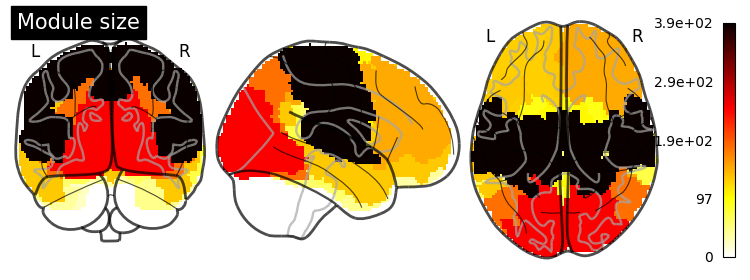

In [33]:
module_size_img = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)
idx = 0
for idx, MS in enumerate(module_measures["module size"].values):
    module_size_img[optimal_parcellation_data == idx+1] = MS

plotting.plot_glass_brain(
    nib.Nifti1Image(module_size_img, affine=initial_parcellation.affine),
    colorbar=True,
    title="Module size",
)
nib.save(
    nib.Nifti1Image(module_size_img, affine=initial_parcellation.affine),
    os.path.join(
        project_path, "data", "processed", "n" + str(CONN_SIZE), "module_size.nii.gz"
    ),
)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "figures",
        "opt_parcell_module_size_brain.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

The MH is represented in a brain plot. The figure is saved in the folder `bha2/data/figures` and the image in the folder `bha2/data/processed/CONN_SIZE`.

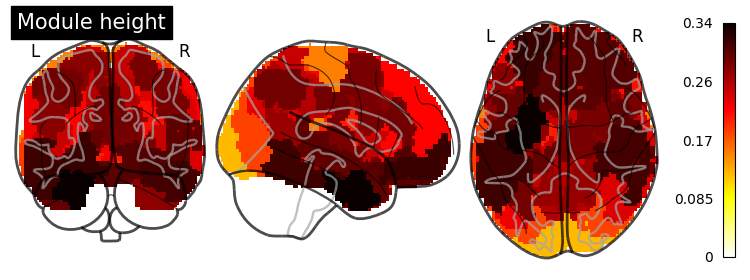

In [34]:
module_heights_img = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)
idx = 0
for idx, MH in enumerate(module_measures["module height"].values):
    module_heights_img[optimal_parcellation_data == idx+1] = MH

plotting.plot_glass_brain(
    nib.Nifti1Image(module_heights_img, affine=initial_parcellation.affine),
    colorbar=True,
    title="Module height",
)
nib.save(
    nib.Nifti1Image(module_heights_img, affine=initial_parcellation.affine),
    os.path.join(
        project_path, "data", "processed", "n" + str(CONN_SIZE), "module_height.nii.gz"
    ),
)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "figures",
        "opt_parcell_module_height_brain.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

In order to get an understanding of the measures, we correlate them with the module intra strength, a measure which is related with the module segregation. We also, correlate the measures between them. Notice that, each dot has a different color, coinciding with the same colors of the modules. The figure is saved in the folder `bha2/data/figures`.

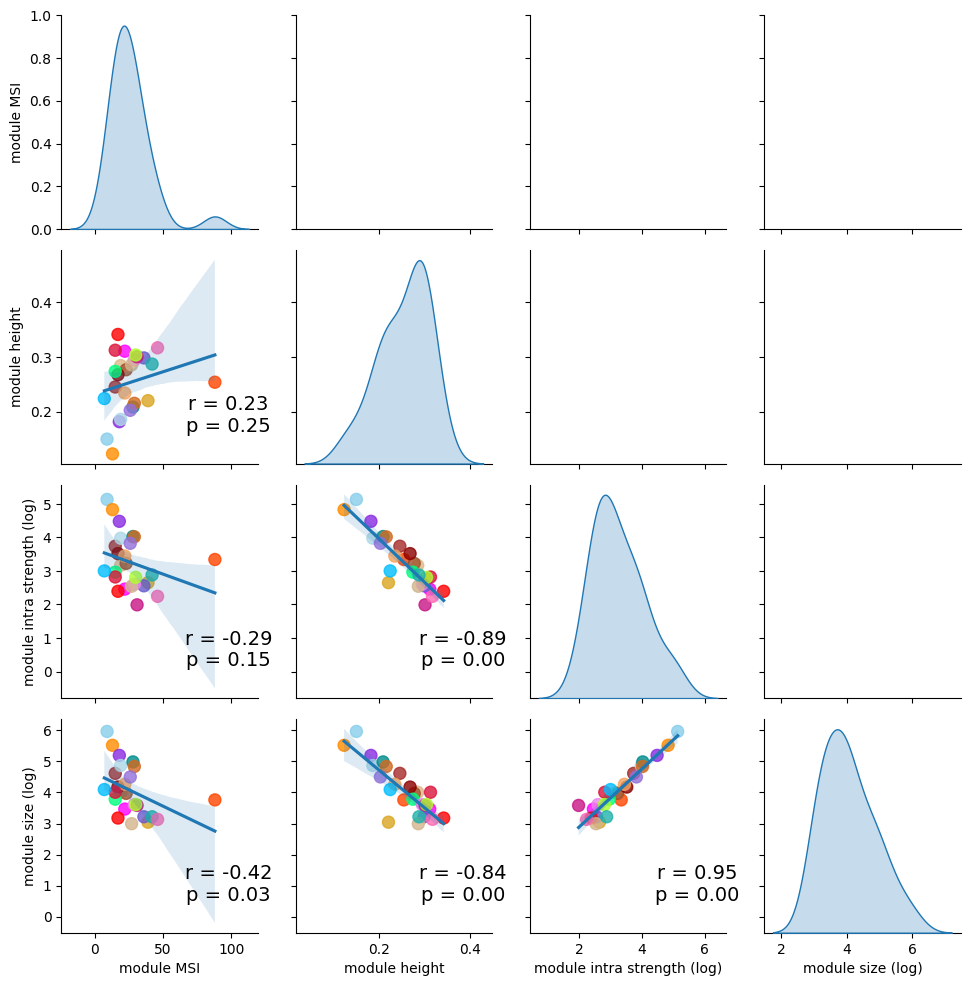

In [35]:
module_measures_corr = module_measures
module_measures_corr["module intra strength (log)"] = np.log(module_measures_corr["module intra strength"])
module_measures_corr["module size (log)"] = np.log(module_measures_corr["module size"])
module_measures_corr.drop(columns=["module intra strength", "module size"], inplace=True)

correlogram = sns.PairGrid(module_measures_corr, diag_sharey=False)

correlogram.map_lower(sns.regplot, scatter_kws={'alpha':0.8, 's': 75, 'color': color_list_ni})
correlogram.map_lower(plot_corr)
correlogram.map_diag(sns.kdeplot, shade=True)
correlogram.savefig(
        os.path.join(project_path, "data", "figures", "dendrogram_variables_correlogram.svg"),
        dpi=300,
        bbox_inches="tight",
        format="svg",
    )